In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
results = pd.read_csv('./baseline_results_train_split.csv')

In [6]:
results

,segmented_ita,direct_ita,kinyananjui_class,empirical_class,kinyananjui_hit,empirical_hit,kinyananjui_relaxed_hit,empirical_relaxed_hit,real_class
0,33.230388,32.043570,3,2,0,1,1,1,2
1,NaN,164.233651,6,6,0,0,0,0,1
2,48.519973,35.469942,2,1,1,0,1,1,2
3,-5.196491,9.876615,6,5,0,0,0,1,4
4,33.253809,55.188757,3,2,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...
14364,29.449512,29.519689,3,2,1,0,1,1,3
14365,38.138477,29.071445,3,2,0,0,1,0,4
14366,53.264299,52.827444,2,1,1,0,1,1,2
14367,38.879170,38.797381,3,2,0,1,1,1,2


Vamos começar analisando a diferença do extrair a informação da imagem inteira e da região segmentada:

In [10]:
results[['segmented_ita','direct_ita']].describe()

,segmented_ita,direct_ita
count,14350.000000,14369.000000
mean,24.017285,17.569868
std,29.638906,44.040528
min,-129.485571,-179.453924
25%,6.862796,-2.859039
50%,24.352593,20.308503
75%,44.207734,45.373512
max,124.480807,178.601928


<AxesSubplot:>

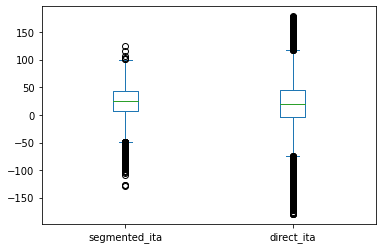

In [11]:
#fig = plt.figure(figsize =(10, 7))
 
# Creating plot
results[['segmented_ita','direct_ita']].plot(kind='box')

É possível ver que a extração direta apresenta variância muito maior, com uma maior presença de outliers. Considerendo que este é um dataset dermatoscópico, boa parte das imagens já são apenas de pele, porém um dataset de faces apresentaria uma necessidade ainda maior de segmentação.

Vamos agora analisar os resultados. Existem duas tabelas de classificação, a utilizada por Kinyananjui e a utilizado pelos autores do paper Fitzpatrick17k que foram calculados de maneira a maximizar o acerto neste dataset (parece uma abordagem bayseana?). Vamos comparar o resultado das duas no treino.

In [12]:
n_rows = len(results)

print(f"Acurácia obtida utilizando tabela Kinyananjui: {results['kinyananjui_hit'].sum()/n_rows*100:.2f}%")
print(f"Acurácia obtida utilizando valores empíricos: {results['empirical_hit'].sum()/n_rows*100:.2f}%")

Acurácia obtida utilizando tabela Kinyananjui: 26.22%
Acurácia obtida utilizando valores empíricos: 34.00%


Acerto superior ao classificador aleatório (16.66%)

Como o dataset é desbalanceado, vamos usar a balanced_accuracy para uma métrica que capture melhor esse desbalanceamento.

In [18]:
from sklearn.metrics import balanced_accuracy_score

print(f"Acurácia balanceada utilizando tabela Kinyananjui: {balanced_accuracy_score(results['real_class'],results['kinyananjui_class']):.2f}")
print(f"Acurácia obtida utilizando valores empíricos: {balanced_accuracy_score(results['real_class'],results['empirical_class']):.2f}")

Acurácia balanceada utilizando tabela Kinyananjui: 0.32
Acurácia obtida utilizando valores empíricos: 0.35


Também é utilizado no artigo a métrica de acurácia considerando um nível de erro, ou seja, caso a classe verdadeira seja 3, o classificador terá acertado se responder 4 ou 2.

In [7]:
n_rows = len(results)

print(f"Acurácia obtida utilizando tabela Kinyananjui: {results['kinyananjui_relaxed_hit'].sum()/n_rows*100:.2f}%")
print(f"Acurácia obtida utilizando valores empíricos: {results['empirical_relaxed_hit'].sum()/n_rows*100:.2f}%")

Acurácia obtida utilizando tabela Kinyananjui: 61.41%
Acurácia obtida utilizando valores empíricos: 74.95%


Podemos selecionar também o acerto por classes:

In [8]:
def results_per_class(results):
    print("fitzpatrick\tN. Instancias\tAcurácia_K\tAcurácia_E\tAcurácia_RK\tAcurácia_RE")
    for i in range(1,7):
        n_rows = len(results.loc[results['real_class']==i])
        print(f"{i}\t\t{n_rows}",end='')
        print(f"\t\t{results.loc[results['real_class']==i]['kinyananjui_hit'].sum()/n_rows*100:.2f}% ",end='')
        print(f"\t\t{results.loc[results['real_class']==i]['empirical_hit'].sum()/n_rows*100:.2f}% ",end='')
        print(f"\t\t{results.loc[results['real_class']==i]['kinyananjui_relaxed_hit'].sum()/n_rows*100:.2f}% ",end='')
        print(f"\t\t{results.loc[results['real_class']==i]['empirical_relaxed_hit'].sum()/n_rows*100:.2f}% ",end='')
        print()
results_per_class(results)

fitzpatrick	N. Instancias	Acurácia_K	Acurácia_E	Acurácia_RK	Acurácia_RE
1		2940		43.84% 		64.73% 		63.30% 		79.52% 
2		4796		18.95% 		27.44% 		59.34% 		80.28% 
3		3299		23.37% 		22.52% 		54.08% 		71.20% 
4		2776		17.90% 		26.26% 		51.95% 		70.35% 
5		1527		14.67% 		35.76% 		89.26% 		69.88% 
6		628		74.68% 		30.57% 		81.05% 		65.13% 


Vemos que existe uma grande variância nos erros em relação a cada classe e quando utilizamos a regra "relaxada" essa variância diminui. 